# Assignment 1
### Natarajan

In [2]:
import numpy as np
np.random.seed(13) #TODO Check if this is used for sgd
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Reshape, Lambda
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import model_to_dot
from keras.preprocessing import sequence
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors as nn
from matplotlib import pylab
from __future__ import division

C:\Users\V\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\V\Anaconda3\envs\tensorflow\lib\site-packages\gensim\utils.py:1167: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
path = 'alice.txt'
corpus = open(path).readlines()[0:700]

corpus = [sentence for sentence in corpus if sentence.count(" ") >= 2]

tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'+"'")
tokenizer.fit_on_texts(corpus)
corpus = tokenizer.texts_to_sequences(corpus)
nb_samples = sum(len(s) for s in corpus)
V = len(tokenizer.word_index) + 1
#print(tokenizer.word_index['alice'])

dim = 100
window_size = 2 #window size for Skipgram, CBOW, and the model with the additional hidden layer
window_size_corpus = 4 #window size for the co-occurrence matrix

## Question 1

### Co-occurrence Matrix
Use the provided code to load the "Alice in Wonderland" text document. 
1. Implement the word-word co-occurrence matrix for “Alice in Wonderland”
2. Normalize the words such that every value lies within a range of 0 and 1
3. Compute the cosine distance between the given words:
    - Alice 
    - Dinah
    - Rabbit
4. List the 5 closest words to 'Alice'. Discuss the results.
5. Discuss what the main drawbacks are of a term-term co-occurence matrix solutions?


In [4]:
#create co-occurrence matrix

co_matrix = np.zeros((V,V))
tokens = []
context_ids = []
for s in corpus:
    for w in s:
        tokens.append(w)
L=len(tokens)

for target_i, target_w in enumerate(tokens):
        # collect all words in context window of target word
    p = target_i - window_size
    n = target_i + window_size + 1
    
                    
    for i in range(p, n):
        if i != target_i and 0 <= i < L:
            co_matrix[target_w, tokens[i]] += 1
            
import sklearn.preprocessing as pp
#Normalising Co-occurrence matrix row-wise
nco_matrix = pp.normalize(co_matrix, norm='l2', axis=0)

In [5]:
#find cosine similarity to Alice, Dinah and Rabbit
print('Cosine Similarity of Alice and Rabbit:', np.dot(nco_matrix[tokenizer.word_index['alice']], nco_matrix[tokenizer.word_index['rabbit']]))
print('Cosine Similarity of Alice and Dinah:', np.dot(nco_matrix[tokenizer.word_index['alice']], nco_matrix[tokenizer.word_index['dinah']]))
print('Cosine Similarity of Rabbit and Dinah:', np.dot(nco_matrix[tokenizer.word_index['rabbit']], nco_matrix[tokenizer.word_index['dinah']]))

Cosine Similarity of Alice and Rabbit: 0.44066118703476215
Cosine Similarity of Alice and Dinah: 0.2795102864577938
Cosine Similarity of Rabbit and Dinah: 0.11501351602339502


In [6]:
#find the closest words to Alice
from sklearn.neighbors import NearestNeighbors
alice_nbrs = NearestNeighbors(n_neighbors=5, metric='euclidean')
alice_nbrs.fit(co_matrix) 
n_alice = alice_nbrs.kneighbors(np.array(co_matrix[tokenizer.word_index['alice']]).reshape(1,-1))
print('Closest words to Alice: ')
closest = np.asarray(n_alice[1])
for i in closest:
    for j in i:
        for word,k in tokenizer.word_index.items():
            if(k == j):
                print(word)

Closest words to Alice: 
alice
herself
that
very
her


Discussion of the drawbacks:
For a co-occurence matrix, the length of the word equals the size of the vocabulary. So the dimensions of the matrix reach |size of vocabulary|X|size of vocabulary|. Also, the resulting matrix is very sparse. This takes up a lot of space and increases the cost of computing. It is unable to capture meaning. Intuitively, simple, raw frequency is not the best measure of association between words. It tends to be skewed and not so discriminative. Words like 'it', 'the', 'are' which occur frequently with all types of words just act like noise and do not provide any significant information about particular words. On the other hand, it also strips the meaning from words that commonly appear together like 'Soviet' and 'Union'. If one wants to know what contexts are shared by a particular set of words but not by some other set of words, a co-occurrence matrix doesn't seem very helpful. This measure does not tell us how much more often than chance two words co-occur. Hence other dense and efficient representations with possibilities of information conservation need to be explored.

In [7]:
#Save your all the vector representations of your word embeddings in this way
#Change when necessary the sizes of the vocabulary/embedding dimension

f = open('vectors_co_occurrence.txt',"w")
f.write(" ".join([str(V-1),str(V-1)]))
f.write("\n")

#vectors = your word co-occurrence matrix
vectors = co_matrix
for word, i in tokenizer.word_index.items():    
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(vectors[i,:]))))
    f.write("\n")
f.close()

In [33]:
#reopen your file as follows

co_occurrence = KeyedVectors.load_word2vec_format('./vectors_co_occurrence.txt', binary=True)

## Question 2

### Word embeddings
Build embeddings with a keras implementation where the embedding vector is of length 50, 150 and 300. Use the Alice in Wonderland text book for training.
1. Using the CBOW model
2. Using Skipgram model
3. Add extra hidden dense layer to CBow and Skipgram implementations. Choose an activation function for that layer and justify your answer.
4. Analyze the four different word embeddings
    - Implement your own function to perform the analogy task with. Do not use existing libraries for this task such as Gensim. Your function should be able to answer whether an anaology as in the example given in the pdf-file is true.
    - Compare the performance on the analogy task between the word embeddings that you have trained in 2.1, 2.2 and 2.3.  
    - Visualize your results and interpret your results
5. Use the word co-occurence matrix from Question 1. Compare the performance on the analogy task with the performance of your trained word embeddings.  
6. Discuss:
    - What are the main advantages of CBOW and Skipgram?
    - What is the advantage of negative sampling?
    - What are the main drawbacks of CBOW and Skipgram?
7. Load pre-trained embeddings on large corpuses (see the pdf file). You only have to consider the word embeddings with an embedding size of 300
    - Compare performance on the analogy task with your own trained embeddings from "Alice in Wonderland". You can limit yourself to the vocabulary of Alice in Wonderland. Visualize the pre-trained word embeddings and compare these with the results of your own trained word embeddings. 


In [8]:
#prepare data for cbow
def generate_data(corpus, window_size, V):
    maxlen = window_size
    for words in corpus:
        L = len(words)
        for index, word in enumerate(words):
            contexts = []
            labels   = []            
            s = index - window_size
            e = index + window_size + 1
            
            contexts.append([words[i] for i in range(s, e) if 0 <= i < L and i != index])
            labels.append(word)

            x = sequence.pad_sequences(contexts, maxlen=maxlen)
            #enc = OneHotEncoder()
            #enc.fit(x)
            y = np_utils.to_categorical(labels, V)
            yield (x, y)


In [9]:
#create CBOW model
#CBOW with embedding vector length 50
cbow_50 = Sequential()
cbow_50.add(Embedding(input_dim=V, output_dim=50, input_length=window_size))
cbow_50.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(50,)))
cbow_50.add(Dense(V, activation='softmax'))


#CBOW with embedding vector length 150
cbow_150 = Sequential()
cbow_150.add(Embedding(input_dim=V, output_dim=150, input_length=window_size))
cbow_150.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(150,)))
cbow_150.add(Dense(V, activation='softmax'))


#CBOW with embedding vector length 300
cbow_300 = Sequential()
cbow_300.add(Embedding(input_dim=V, output_dim=300, input_length=window_size))
cbow_300.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(300,)))
cbow_300.add(Dense(V, activation='softmax'))


In [10]:
#define loss function
#Loss function for CBOW with embedding vector length 50
cbow_50.compile(loss='categorical_crossentropy', optimizer='adadelta')

#Loss function for CBOW with embedding vector length 150
cbow_150.compile(loss='categorical_crossentropy', optimizer='adadelta')

#Loss function for CBOW with embedding vector length 300
cbow_300.compile(loss='categorical_crossentropy', optimizer='adadelta')

In [11]:
#train model
print('CBOW with embedding vector length 50')
for ite in range(10):
    loss = 0.
    for x, y in generate_data(corpus, window_size, V):
        loss += cbow_50.train_on_batch(x, y)
    print(ite, loss)

        
print('CBOW with embedding vector length 150')
for ite in range(10):
    loss = 0.
    for x, y in generate_data(corpus, window_size, V):
        loss += cbow_150.train_on_batch(x, y)
    print(ite, loss)
        
        

print('CBOW with embedding vector length 300')
for ite in range(10):
    loss = 0.
    for x, y in generate_data(corpus, window_size, V):
        loss += cbow_300.train_on_batch(x, y)
    print(ite, loss)
    
#saving embeddings
#D 50
f = open('vectors_cbow_50.txt' ,'w')
f.write(" ".join([str(V-1),str(50)]))
f.write("\n")

vectors = cbow_50.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(vectors[i,:]))))
    f.write("\n")
f.close()



#D 150
f = open('vectors_cbow_150.txt' ,'w')
f.write(" ".join([str(V-1),str(150)]))
f.write("\n")

vectors = cbow_150.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(vectors[i,:]))))
    f.write("\n")
f.close()


#D 300
f = open('vectors_cbow_300.txt' ,'w')
f.write(" ".join([str(V-1),str(300)]))
f.write("\n")

vectors = cbow_300.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(vectors[i,:]))))
    f.write("\n")
f.close()

CBOW with embedding vector length 50
0 41706.42745757103
1 39279.66142761707
2 39367.64521420002
3 39455.23206979036
4 39544.791580051184
5 39670.303632736206
6 39810.597569048405
7 39957.98351494223
8 40099.48428956792
9 40228.040139770135
CBOW with embedding vector length 150
0 41662.211533784866
1 38967.81661903858
2 38818.02530288696
3 38738.7473346889
4 38721.89259688556
5 38729.7782333754
6 38739.446675144136
7 38734.42711516563
8 38713.98339716671
9 38681.603715459816
CBOW with embedding vector length 300
0 41612.854576826096
1 38704.87019318342
2 38393.302914470434
3 38234.97086049616
4 38125.30246315524
5 38031.98594771698
6 37937.770226878114
7 37836.92944164947
8 37724.73679540469
9 37598.40205563861


In [12]:
#prepare data for Skipgram
def generate_data_skipgram(corpus, window_size, V):
    maxlen = window_size
    all_in = []
    all_out = []
    for words in corpus:
        L = len(words)
        for index, word in enumerate(words):
            p = index - window_size
            n = index + window_size + 1
                    
            in_words = []
            labels = []
            for i in range(p, n):
                if i != index and 0 <= i < L:
                    in_words.append([word])
                    labels.append(words[i])
            if in_words != []:
                all_in.append(np.array(in_words,dtype=np.int32))
                all_out.append(np_utils.to_categorical(labels, V))
    return (all_in,all_out)

targets,contexts = generate_data_skipgram(corpus,window_size,V)

In [13]:
#create Skipgram model
#Skipgram with embedding vector length 50
skipgram_50 = Sequential()
skipgram_50.add(Embedding(input_dim=V, output_dim=50, embeddings_initializer='glorot_uniform', input_length=1))
skipgram_50.add(Reshape((50, )))
skipgram_50.add(Dense(input_dim=50, units=V, kernel_initializer='uniform', activation='softmax'))

#Skipgram with embedding vector length 150
skipgram_150 = Sequential()
skipgram_150.add(Embedding(input_dim=V, output_dim=150, embeddings_initializer='glorot_uniform', input_length=1))
skipgram_150.add(Reshape((150, )))
skipgram_150.add(Dense(input_dim=150, units=V, kernel_initializer='uniform', activation='softmax'))


#Skipgram with embedding vector length 300
skipgram_300 = Sequential()
skipgram_300.add(Embedding(input_dim=V, output_dim=300, embeddings_initializer='glorot_uniform', input_length=1))
skipgram_300.add(Reshape((300, )))
skipgram_300.add(Dense(input_dim=300, units=V, kernel_initializer='uniform', activation='softmax'))

In [14]:
#define loss function for Skipgram
#Loss function for Skipgram with embedding vector length 50
skipgram_50.compile(loss='categorical_crossentropy', optimizer='adadelta')


#Loss function for Skipgram with embedding vector length 50
skipgram_150.compile(loss='categorical_crossentropy', optimizer='adadelta')


#Loss function for Skipgram with embedding vector length 50
skipgram_300.compile(loss='categorical_crossentropy', optimizer='adadelta')

In [15]:
#train Skipgram model
print('Skipgram with embedding vector length 50')
for ite in range(10):
    loss = 0.
    for x, y in zip(targets, contexts):
        loss += skipgram_50.train_on_batch(x, y) 
    
    print(ite, loss)    
    
    
print('Skipgram with embedding vector length 150')
for ite in range(10):
    loss = 0.
    for x, y in zip(targets, contexts):
        loss += skipgram_150.train_on_batch(x, y)    
    
    print(ite, loss)
    

print('Skipgram with embedding vector length 300')
for ite in range(10):
    loss = 0.
    for x, y in zip(targets, contexts):
        loss += skipgram_300.train_on_batch(x, y)        
      
    print(ite, loss)

#saving embeddings
#D 50
f = open('vectors_skipgram_50.txt' ,'w')
f.write(" ".join([str(V-1),str(50)]))
f.write("\n")

vectors = skipgram_50.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(vectors[i,:]))))
    f.write("\n")
f.close()


#D 150
f = open('vectors_skipgram_150.txt' ,'w')
f.write(" ".join([str(V-1),str(150)]))
f.write("\n")

vectors = skipgram_150.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(vectors[i,:]))))
    f.write("\n")
f.close()


#D 300
f = open('vectors_skipgram_300.txt' ,'w')
f.write(" ".join([str(V-1),str(300)]))
f.write("\n")

vectors = skipgram_300.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(vectors[i,:]))))
    f.write("\n")
f.close()


Skipgram with embedding vector length 50
0 41271.83740758896
1 39101.409803152084
2 39265.024810791016
3 39357.28198981285
4 39443.991062402725
5 39536.583912968636
6 39641.83394193649
7 39760.61473596096
8 39890.633348464966
9 40026.53588759899
Skipgram with embedding vector length 150
0 41215.42259097099
1 38922.63101768494
2 38984.98606240749
3 39005.48298621178
4 39030.084755539894
5 39068.80780386925
6 39119.432270526886
7 39171.63411653042
8 39215.130346894264
9 39248.59214627743
Skipgram with embedding vector length 300
0 41158.6715927124
1 38737.37706589699
2 38703.31194841862
3 38658.18408882618
4 38628.110095858574
5 38608.342851519585
6 38582.7425839901
7 38541.39114379883
8 38489.79677951336
9 38436.14224815369


In [16]:
#create CBOW model with additional dense layer
#CBOW with embedding vector length 50 & additional layer
cbow_additional_50 = Sequential()
cbow_additional_50.add(Embedding(input_dim=V, output_dim=50, input_length=window_size))
cbow_additional_50.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(50,)))
cbow_additional_50.add(Dense(V, activation='relu'))
cbow_additional_50.add(Dense(V, activation='softmax'))


#CBOW with the embedding vector length 150 & additional layer
cbow_additional_150 = Sequential()
cbow_additional_150.add(Embedding(input_dim=V, output_dim=150, input_length=window_size))
cbow_additional_150.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(150,)))
cbow_additional_150.add(Dense(V, activation='relu'))
cbow_additional_150.add(Dense(V, activation='softmax'))



#cBOW with the embedding vector length 300 & additional layer
cbow_additional_300 = Sequential()
cbow_additional_300.add(Embedding(input_dim=V, output_dim=300, input_length=window_size))
cbow_additional_300.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(300,)))
cbow_additional_300.add(Dense(V, activation='relu'))
cbow_additional_300.add(Dense(V, activation='softmax'))

In [17]:
#define loss function for CBOW + dense
#Loss function for CBOW with embedding vector length 50
cbow_additional_50.compile(loss='categorical_crossentropy', optimizer='adadelta')

#Loss function for CBOW with embedding vector length 150
cbow_additional_150.compile(loss='categorical_crossentropy', optimizer='adadelta')

#Loss function for CBOW with embedding vector length 300
cbow_additional_300.compile(loss='categorical_crossentropy', optimizer='adadelta')

In [18]:
#train model for CBOW + dense
print('CBOW with embedding vector length 50 & additional dense layer')
for ite in range(10):
    loss = 0.
    for x, y in generate_data(corpus, window_size, V):
        loss += cbow_additional_50.train_on_batch(x, y)
    
    print(ite, loss)

print('CBOW with embedding vector length 150 & additional dense layer')
for ite in range(10):    
    loss = 0.
    for x, y in generate_data(corpus, window_size, V):
        loss += cbow_additional_150.train_on_batch(x, y)
        
    print(ite, loss)        
        

print('CBOW with embedding vector length 300 & additional dense layer')
for ite in range(10):     
    loss = 0.
    for x, y in generate_data(corpus, window_size, V):
        loss += cbow_additional_300.train_on_batch(x, y)
        
    print(ite, loss)
    
    
#Saving embeddings    
#D 50
f = open('vectors_cbow_50_extralayer.txt' ,'w')
f.write(" ".join([str(V-1),str(50)]))
f.write("\n")

vectors = cbow_additional_50.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(vectors[i,:]))))
    f.write("\n")
f.close()


#D 150
f = open('vectors_cbow_150_extralayer.txt' ,'w')
f.write(" ".join([str(V-1),str(150)]))
f.write("\n")

vectors = cbow_additional_150.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(vectors[i,:]))))
    f.write("\n")
f.close()


#D 300
f = open('vectors_cbow_300_extralayer.txt' ,'w')
f.write(" ".join([str(V-1),str(300)]))
f.write("\n")

vectors = cbow_additional_300.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(vectors[i,:]))))
    f.write("\n")
f.close()
        


CBOW with embedding vector length 50 & additional dense layer
0 39814.230287730694
1 38536.293421551585
2 38105.418126333505
3 37760.34209753014
4 37612.57021979103
5 37463.17937352951
6 37382.93876939919
7 37358.89316943893
8 37370.50462853967
9 37413.59636915638
CBOW with embedding vector length 150 & additional dense layer
0 39557.234730392694
1 38077.07491814718
2 37513.456573611125
3 37122.754705279134
4 36876.96611252753
5 36641.68008552893
6 36485.44391882318
7 36320.65210971763
8 36335.387536746304
9 36194.79781166429
CBOW with embedding vector length 300 & additional dense layer
0 39580.39524100721
1 37758.628262426704
2 37236.76525662653
3 36865.17167218658
4 36536.96554810903
5 36225.90024172366
6 35950.69884131888
7 35785.09061293212
8 35642.32120166447
9 35811.43960756071


In [19]:
#create Skipgram with additional dense layer
#Skipgram with embedding vector length 50 & additional layer
skipgram_additional_50 = Sequential()
skipgram_additional_50.add(Embedding(input_dim=V, output_dim=50, embeddings_initializer='glorot_uniform', input_length=1))
skipgram_additional_50.add(Reshape((50, )))
skipgram_additional_50.add(Dense(input_dim=50, units=V, kernel_initializer='uniform', activation='relu'))
skipgram_additional_50.add(Dense(input_dim=50, units=V, kernel_initializer='uniform', activation='softmax'))


#Skipgram with embedding vector length 150 & additional layer
skipgram_additional_150= Sequential()
skipgram_additional_150.add(Embedding(input_dim=V, output_dim=150,embeddings_initializer='glorot_uniform', input_length=1))
skipgram_additional_150.add(Reshape((150, )))
skipgram_additional_150.add(Dense(input_dim=150, units=V, kernel_initializer='uniform', activation='relu'))
skipgram_additional_150.add(Dense(input_dim=150, units=V, kernel_initializer='uniform', activation='softmax'))


#Skipgram with embedding vector length 300 & additional layer
skipgram_additional_300= Sequential()
skipgram_additional_300.add(Embedding(input_dim=V, output_dim=300,embeddings_initializer='glorot_uniform', input_length=1))
skipgram_additional_300.add(Reshape((300, )))
skipgram_additional_300.add(Dense(input_dim=300, units=V, kernel_initializer='uniform', activation='relu'))
skipgram_additional_300.add(Dense(input_dim=300, units=V, kernel_initializer='uniform', activation='softmax'))

Activation function ReLU has been chosen since it is sparse but efficient. Fewer neurons fire which makes the network light.
This would be preferable since for word embedding networks there are already too many neurons working at the huge 
vocabulary of words. There is also reduced likelihood of vanishing gradient.

In [20]:
#define loss function for Skipgram + dense
skipgram_additional_50.compile(loss='categorical_crossentropy', optimizer='adadelta')
skipgram_additional_150.compile(loss='categorical_crossentropy', optimizer='adadelta')
skipgram_additional_300.compile(loss='categorical_crossentropy', optimizer='adadelta')

In [21]:
#train model for Skipgram + dense. 
print('Skipgram with embedding vector length 50 & additional layer')
for ite in range(10):   
    loss = 0.
    for x, y in zip(targets, contexts):
        loss += skipgram_additional_50.train_on_batch(x, y)   
    
   
    print(ite, loss)
    
print('Skipgram with embedding vector length 150 & additional layer')
for ite in range(10):   
    loss = 0.
    for x, y in zip(targets, contexts):
        loss += skipgram_additional_150.train_on_batch(x, y)   
    
   
    print(ite, loss)
    
print('Skipgram with embedding vector length 300 & additional layer')
for ite in range(10):   
    loss = 0.
    for x, y in zip(targets, contexts):
        loss += skipgram_additional_300.train_on_batch(x, y)   
    
   
    print(ite, loss)
    
#saving embeddings    
#D 50
f = open('vectors_skipgram_50_extralayer.txt' ,'w')
f.write(" ".join([str(V-1),str(50)]))
f.write("\n")

vectors = skipgram_additional_50.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(vectors[i,:]))))
    f.write("\n")
f.close()



#D 150
f = open('vectors_skipgram_150_extralayer.txt' ,'w')
f.write(" ".join([str(V-1),str(150)]))
f.write("\n")

vectors = skipgram_additional_150.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(vectors[i,:]))))
    f.write("\n")
f.close()


#D 300
f = open('vectors_skipgram_300_extralayer.txt' ,'w')
f.write(" ".join([str(V-1),str(300)]))
f.write("\n")

vectors = skipgram_additional_300.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write(word)
    f.write(" ")
    f.write(" ".join(map(str, list(vectors[i,:]))))
    f.write("\n")
f.close()

Skipgram with embedding vector length 50 & additional layer
0 38547.812596559525
1 38199.15345406532
2 38012.36969947815
3 37793.58448755741
4 37748.94483220577
5 37673.55266058445
6 37647.03285801411
7 37651.03945398331
8 37689.067876935005
9 37747.15191805363
Skipgram with embedding vector length 150 & additional layer
0 38497.728229522705
1 38140.36464929581
2 38043.48129963875
3 37967.95831120014
4 37990.72313416004
5 38111.00869631767
6 38198.29317975044
7 38292.81537044048
8 38351.4223151207
9 38474.77241104841
Skipgram with embedding vector length 300 & additional layer
0 38540.52293300629
1 38289.23558473587
2 38052.059272408485
3 38257.44911777973
4 38561.39910387993
5 38892.81957042217
6 39278.39689743519
7 39354.309168219566
8 39539.659068048
9 39763.95253652334


In [24]:
#Implement your own analogy function

def analogyfun(word_list, em_path):
#em_matrix = KeyedVectors.load_word2vec_format(em_path, binary=True)

    embeddings = [] 

    with open(em_path) as f:
        contents = [[x.strip('\n').split()] for x in f.readlines()]

    for x in contents:
        for y in x:
            embeddings.append(y)

    embeddings.pop(0) 
  
    vectors = []
    
    for word in word_list:
        for row in embeddings:
            if word in row:
                vectors.append(row)
    
    if(len(vectors) != 4):
        print("All words not present for comparision")
        return -1
    
    for word,vector in zip(word_list,vectors):
        if(word in vector):
            vector.remove(word)
            
    vectors = [[float(i) for i in vector]for vector in vectors] 
    
    #analogy calcuations (if(v2 == v0 - v1 + v3))
    x = [v2 + v1 for v1, v2 in zip(vectors[1], vectors[3])]
    y = [v1 - v2 for v1, v2 in zip(vectors[0], x)]
    flag = 0
    for first,second in zip(y,vectors[2]):
        if(first == second):
            flag=1
        else:
            flag=0
   
    return flag  



word_lists = []
with open('analogy_alice.txt') as f:
        contents = [[x.strip('\n').split()] for x in f.readlines()]

for x in contents:
    word_lists.append('0')
    for y in x:
        word_lists.append(y)

files = ['vectors_cbow_50.txt', 'vectors_cbow_150.txt', 'vectors_cbow_300.txt', 'vectors_cbow_50_extralayer.txt', 'vectors_cbow_150_extralayer.txt', 'vectors_cbow_300_extralayer.txt','vectors_skipgram_50.txt','vectors_skipgram_150.txt','vectors_skipgram_300.txt','vectors_skipgram_300_extralayer.txt','vectors_skipgram_50_extralayer.txt','vectors_skipgram_150_extralayer.txt','vectors_co_occurrence.txt']
status=[]

for path in files:
    true_count=0
    false_count=0
    for word_list in word_lists:
    #print(word_list)
        x = analogyfun(word_list, path)
        if (x == 1):
        #print('true')
            
            true_count+=1
        elif (x==0):
            
            false_count+=1

    status.append([true_count,false_count])

for path,count in zip(files,status):
    print(path)
    print('True: ', count[0], 'False: ', count[1] )

All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words no

All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words no

All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words no

All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words no

All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words no

All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words no

All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words no

All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words no

All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words no

Comparison performance: None of the variants of CBOW or Skipgram models were able to perform the analogies. The co-occurrence 
matrix found 39 analogies from the given analogy task file. 

In [30]:
def embedding_toMatrix(path):
    with open(path) as f:
        embedding = f.readlines()

        vectors = [x.strip() for x in embedding] 

    
    size = vectors[0].split(' ')
    for i in range(len(size)):
        size[i] = int(size[i])
    
    rows = []
    rows.append([0]*size[1])
    for i in range(1, int(size[0])+1):
        rows.append(list(map(float, np.asarray(vectors[i].split(' ')[1:size[1]+1]))))
    
    matrix = np.asarray(rows)
    
    return matrix

import sklearn.decomposition as t
matrix_skipgram_50 = embedding_toMatrix('vectors_skipgram_50.txt')
matrix_skipgram_150 = embedding_toMatrix('vectors_skipgram_150.txt')
pca = t.TruncatedSVD(50)
matrix_sg_150 = pca.fit_transform(matrix_skipgram_150)
matrix_skipgram_300 = embedding_toMatrix('vectors_skipgram_300.txt')
matrix_sg_300 = pca.fit_transform(matrix_skipgram_300)

matrix_cbow_50 = embedding_toMatrix('vectors_cbow_50.txt')
matrix_cbow_150 = embedding_toMatrix('vectors_cbow_150.txt')
matrix_cb_150 = pca.fit_transform(matrix_cbow_150)
matrix_cbow_300 = embedding_toMatrix('vectors_cbow_300.txt')
matrix_cb_300 = pca.fit_transform(matrix_cbow_300)

matrix_skipgram_50_el = embedding_toMatrix('vectors_skipgram_50_extralayer.txt')
matrix_skipgram_150_el = embedding_toMatrix('vectors_skipgram_150_extralayer.txt')
matrix_sg_150_el = pca.fit_transform(matrix_skipgram_150_el)
matrix_skipgram_300_el = embedding_toMatrix('vectors_skipgram_300_extralayer.txt')
matrix_sg_300_el = pca.fit_transform(matrix_skipgram_300_el)

matrix_cbow_50_el = embedding_toMatrix('vectors_cbow_50_extralayer.txt')
matrix_cbow_150_el = embedding_toMatrix('vectors_cbow_150_extralayer.txt')
matrix_cb_150_el = pca.fit_transform(matrix_cbow_150_el)
matrix_cbow_300_el = embedding_toMatrix('vectors_cbow_300_extralayer.txt')
matrix_cb_300_el = pca.fit_transform(matrix_cbow_300_el)

#Visualization results trained word embeddings using t-SNE
def extract_words(path):
    with open(path) as f:
        contents = [[x.strip('\n').split()] for x in f.readlines()]
        
        embeddings = []
        words = [0]
        
        for x in contents:
            for y in x:
                embeddings.append(y)
        embeddings.pop(0)
       
        for x in embeddings:
            words.append(x[0])
        return(words)
    
def plot_model(matrix, path, tokenizer = tokenizer):    
    import matplotlib.pyplot as plt

    words=[]
    vectors = []
    selected_vectors = []
    
    dictionary = tokenizer.word_index
    

    no_words_display = 150


    for i in range(1, len(matrix)):
        vectors.append(matrix[i])
        words.append(extract_words(path)[i])
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(vectors)
   
    
    x = []
    y = []
    for value in new_values[1:no_words_display]:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(10, 10)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i]),
        plt.annotate(words[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()


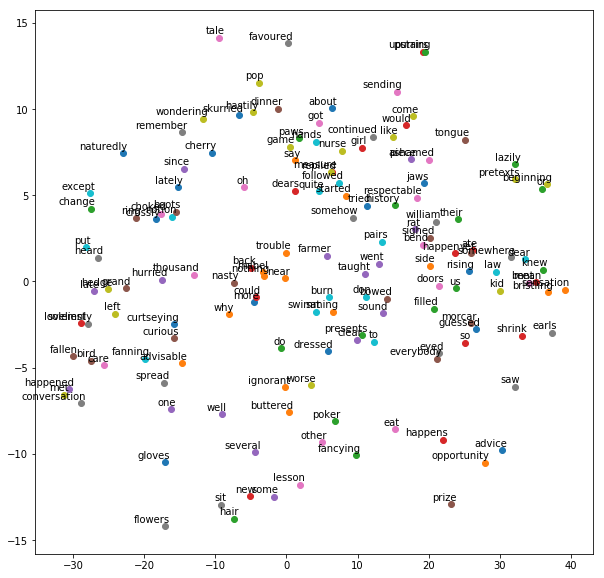

In [31]:
plot_model(matrix_cbow_50, 'vectors_cbow_50.txt')

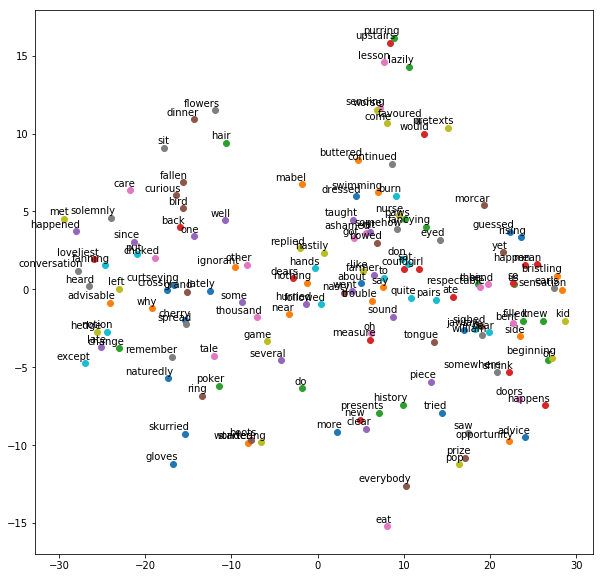

In [32]:
plot_model(matrix_cb_150, 'vectors_cbow_150.txt')

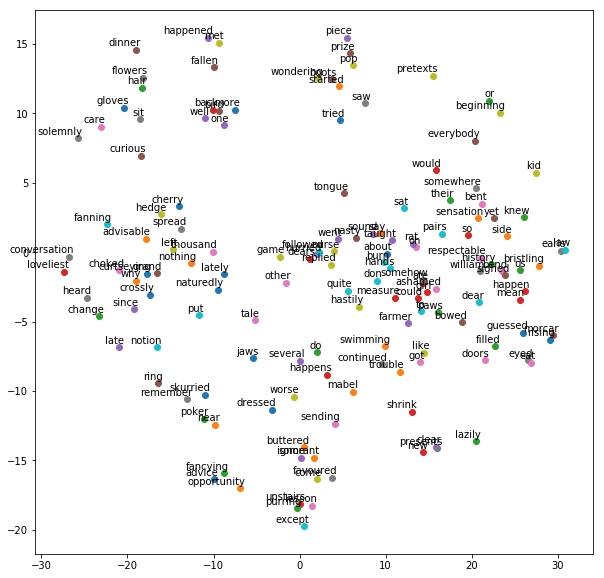

In [33]:
plot_model(matrix_cb_300, 'vectors_cbow_300.txt')

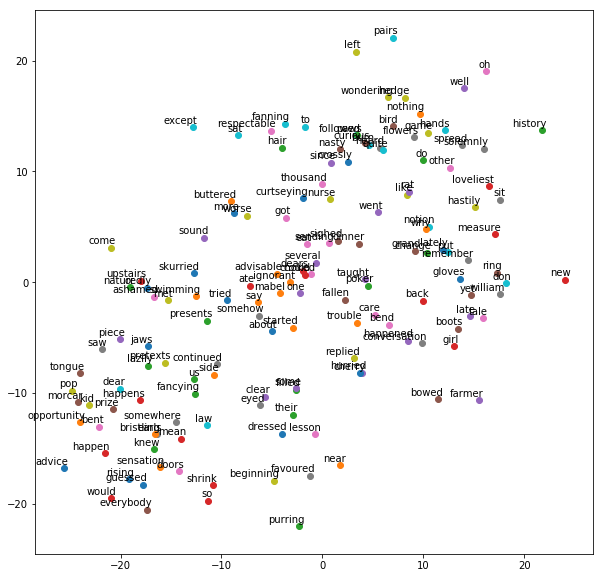

In [34]:
plot_model(matrix_skipgram_50, 'vectors_skipgram_50.txt')

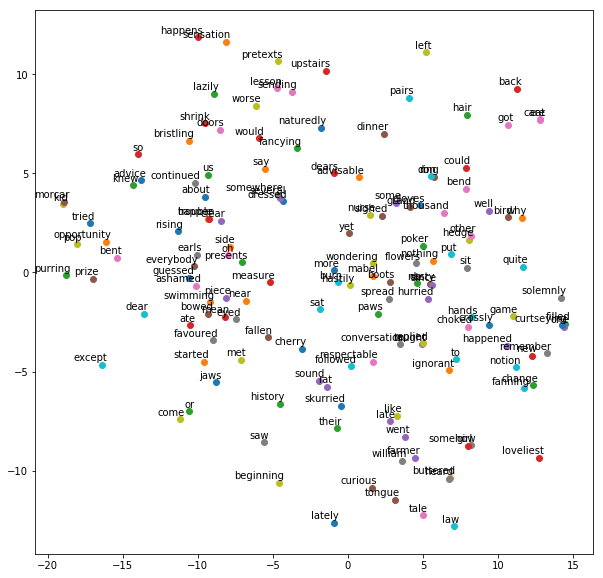

In [35]:
plot_model(matrix_sg_150, 'vectors_skipgram_150.txt')

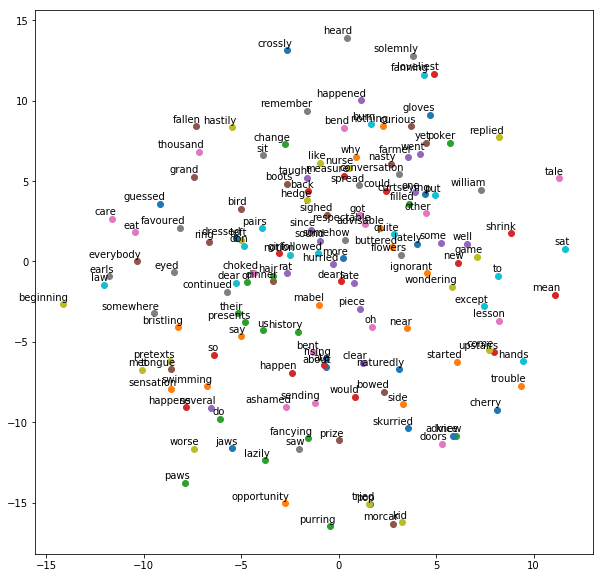

In [36]:
plot_model(matrix_sg_300, 'vectors_skipgram_300.txt')

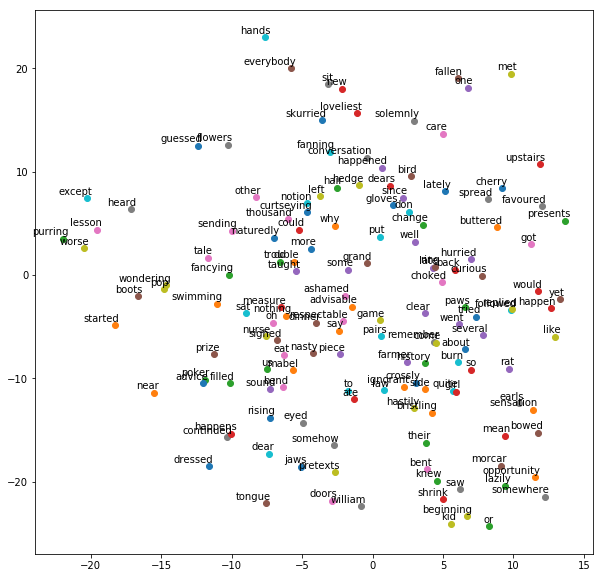

In [37]:
plot_model(matrix_cbow_50_el, 'vectors_cbow_50_extralayer.txt')

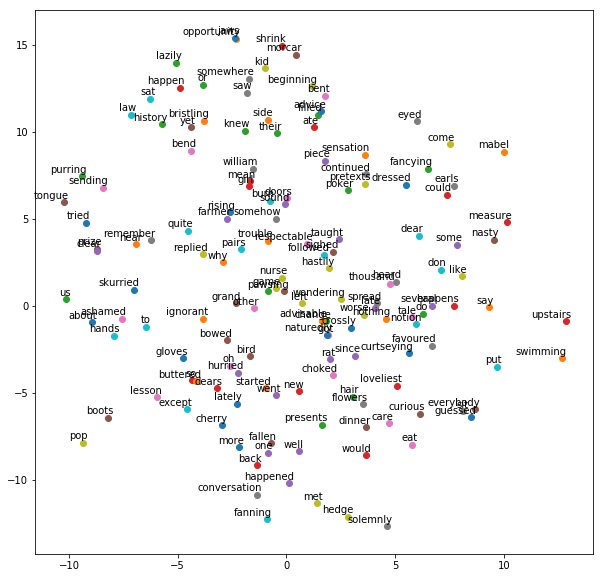

In [38]:
plot_model(matrix_cb_150_el, 'vectors_cbow_150_extralayer.txt')

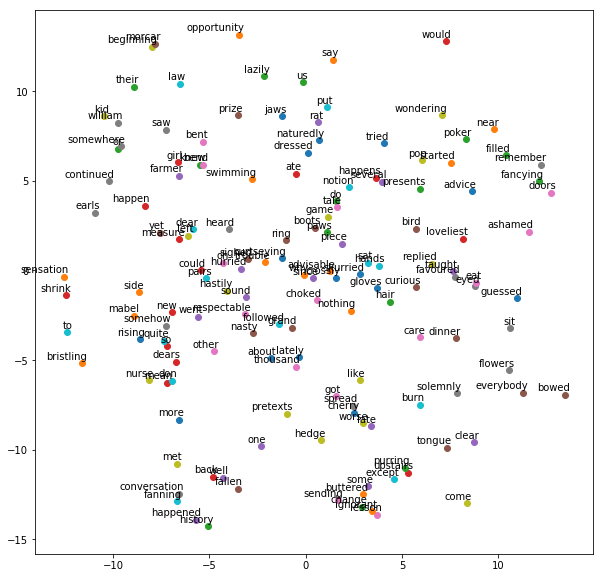

In [39]:
plot_model(matrix_cb_300_el, 'vectors_cbow_300_extralayer.txt')

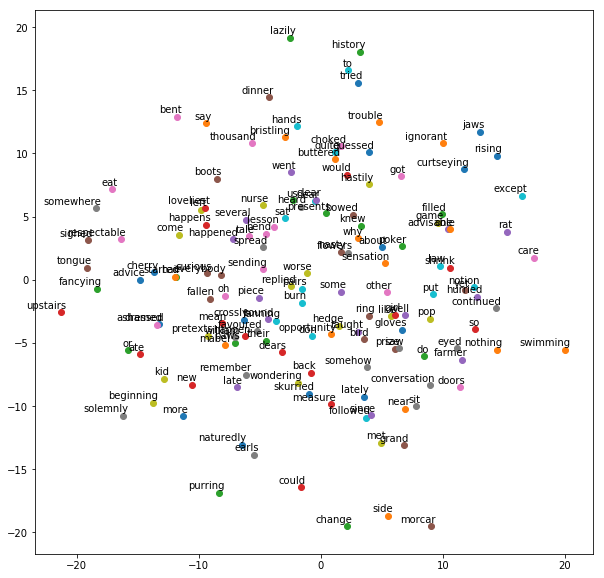

In [40]:
plot_model(matrix_skipgram_50_el, 'vectors_skipgram_50_extralayer.txt')

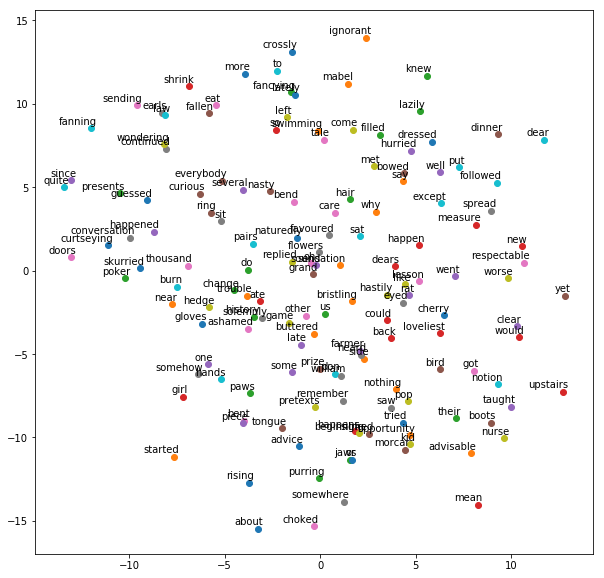

In [41]:
plot_model(matrix_sg_150_el, 'vectors_skipgram_150_extralayer.txt')

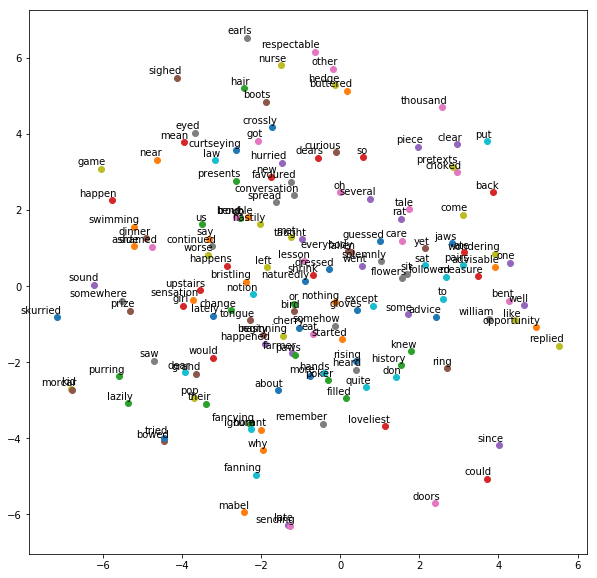

In [42]:
plot_model(matrix_sg_300_el, 'vectors_skipgram_300_extralayer.txt')

Interpretation results of the visualization
Some degree of clustering starts to form as the number of neurons increases. This further is seen to get accentuated with
the addition of hidden layers.

Discussion of the advantages of CBOW and Skipgram, the advantages of negative sampling and drawbacks of CBOW and Skipgram


Advantages of CBOW and Skipgram:
    These are dense representations of word vectors. The dimensions are significantly reduced compared to co-occurrence 
    matrices. This results in lower memory requirements and translates to better efficiency as dense representatons do not 
    involve computationally intensive matrix multiplications.
    The embeddings tend to preserve information about semantics and syntax upto a certain extent. They are more 
    discriminative compared to co-occurrence matrices.
    Pretrained embeddings are available for these methods.
    Fewer dimensions help in generalising better, avoid overfitting, and makes it easier to include as features in machine 
    learning systems
    Meaningful vector operations like addition and subtraction can be performed to gain more insights about the learned words.
    

Advantages of Negative Sampling:
    In the normal softmax function for Skipgram, the cost of calculating the denominator term is proportional to the size 
    of the vocabulary. The input and output vectors need to be multiplied with each other for all the words in the 
    vocabulary and then summed up and processed further.  This is computationally very expensive. Hence negative 
    sampling is used to approximate the denominator, which greatly reduces the computational overhead.
        
Drawbacks of CBOW and Skipgram:
    They are not sensitive to word order. Words appearing together like Great Britain are not identified as phrases. 
    They also cannot capture polysemy.
    
        

In [44]:
#load pretrained word embeddings of word2vec

path_word2vec = "Users\V\Downloads\GoogleNews-vectors-negative300.bin"

word2vec = KeyedVectors.load_word2vec_format(path, binary=True)

In [47]:
#load pretraind word embeddings of Glove

f = open('word2vec.txt' ,'w')
f.write(" ".join([str(V-1),str(150)]))
f.write("\n")

for word, i in tokenizer.word_index.items():
    
    #f.write(" ".join(map(str, list(vectors[i,:]))))
    if word in word2vec:
        #f.write(" ".join(str(word2vec[word])))
        f.write(word)
        f.write(" ")
        for entry in word2vec[word]:
            f.write((str(entry)))
            f.write(" ")   
        f.write("\n")
    else:
        continue
f.close()

import gensim
path = 'glove.6B.300d.txt'

#convert GloVe into word2vec format
gensim.scripts.glove2word2vec.get_glove_info(path)
gensim.scripts.glove2word2vec.glove2word2vec(path, 'glove_converted.txt')

glove = KeyedVectors.load_word2vec_format('glove_converted.txt', binary=False)


#write the embeddings of glove in text file
f = open('glove.txt' ,'w')
f.write(" ".join([str(V-1),str(150)]))
f.write("\n")

for word, i in tokenizer.word_index.items():
    
    #f.write(" ".join(map(str, list(vectors[i,:]))))
    if word in glove:
        f.write(word)
        f.write(" ")
        for entry in glove[word]:
            f.write((str(entry))) 
            f.write(" ")
        f.write("\n")
    else:
        continue
f.close()



files = ['glove.txt', 'word2vec.txt']
see = []
for path in files:
    true_count=0
    false_count=0
    for word_list in word_lists:
    #print(word_list)
        x = analogyfun(word_list, path)
        if (x == 1):
        #print('true')
            
            true_count+=1
        elif (x==0):
            
            false_count+=1

    see.append([true_count,false_count])

for path,count in zip(files,see):
    print(path)
    print('True: ', count[0], 'False: ', count[1] )


All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words not present for comparision
All words no

Glove Model


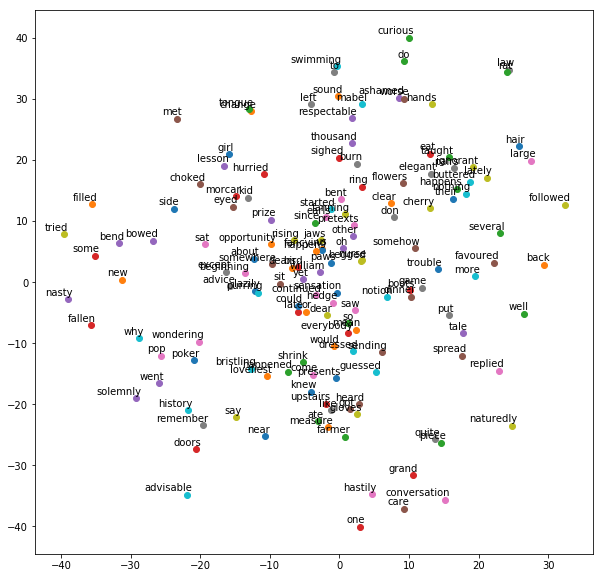

In [50]:
#Visualize the pre-trained word embeddings

def embedding_toM(path):
    contents = []
    embeddings = []
    zero_list=[]
    rows = []

    with open(path) as f:
        for x in f.readlines():
            contents.append([x.strip('\n').split()])
            zero_list.append(0)
    embeddings.append(zero_list) 
    
    for content in contents:
        for y in content:
        
            y.pop(0) 
            embeddings.append(y)
    embeddings.pop(1) 
    
    rows = [[float(i) for i in vector]for vector in embeddings] 
   
    
    matrix = np.asarray(rows)
    return matrix
pca = t.TruncatedSVD(40)
#matrix_sg_150 = pca.fit_transform(matrix_skipgram_150)
matrix_glove = embedding_toM('glove.txt')
#matrix_glove_fit = pca.fit_transform(embedding_toM('glove.txt'))
matrix_word2vec = embedding_toM('word2vec.txt')
#matrix_glove_fit = pca.fit_transform(matrix_word2vec)

print('Glove Model')
plot_model(matrix_glove, 'glove.txt')
#print('Word2vec Model')
#plot_model(matrix_word2vec, 'word2vec.txt')

Comparison performance with your own trained word embeddings

As expected, the words are densely clustered in the glove embedding. They are more scattered in the CBOW and Skipgram 
embeddings. This reflects that the embeddings depend on the training data. The glove model which was trained on a much larger
dataset has richer word clusterings than the CBOW and Skipgram models trained with only the Alice in Wonderland text.